# Relationship between Average LST and Average NDVI
### (Excluding nature areas, parks and water bodies)

Comparing different land uses across Singapore (Mature estates, Non-mature estates, Industrial areas, Downtown core)
- Filtering out nature areas, water bodies and parks

In [1]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import zipfile
from datetime import datetime
import shutil
import logging
import warnings
import hvplot.pandas
from matplotlib.colors import LinearSegmentedColormap

In [1]:
def preprocessing_sg_excl_nature(file_path, singapore_geojson_path, regions_geojson_path, nature_areas_geojson, parks_geojson, water_bodies_geojson):
    # Open your GeoTIFF file
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        src_crs = src.crs  # Source CRS

        # Create a transformer object to convert from src_crs to EPSG:4326 (WGS 84)
        transformer = Transformer.from_crs(src_crs, 'EPSG:4326', always_xy=True)

        # Get arrays of column and row indices
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))

        # Convert meshgrid arrays to coordinate arrays using rasterio's method, which are 2D
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

        # Flatten the coordinate arrays to pass to transform function
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())

        # Create DataFrame and convert to GeoDataFrame
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        # Filter rows where temperature is relevant, assuming a threshold
        df_filtered = df[df['ST_B10'] * 0.00341802 + 149 - 273.15 >= 20]

        # Create a GeoDataFrame from the filtered DataFrame
        gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.Longitude, df_filtered.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)

        # Read the Singapore boundary and exclusion GeoJSONs
        singapore = gpd.read_file(singapore_geojson_path)
        nature_areas = gpd.read_file(nature_areas_geojson).to_crs('EPSG:4326')
        parks = gpd.read_file(parks_geojson).to_crs('EPSG:4326')
        water_bodies = gpd.read_file(water_bodies_geojson).to_crs('EPSG:4326')
        regfoions = gpd.read_file(regions_geojson_path).to_crs('EPSG:4326')

        # Combine all exclusion areas into one GeoDataFrame
        exclusion_areas = gpd.GeoDataFrame(pd.concat([nature_areas, parks, water_bodies], ignore_index=True), crs=nature_areas.crs)

        print(f"Total pixels before any joins: {len(gdf)}")

        # Spatial join to filter and categorize by Singapore boundary
        gdf = gdf.sjoin(singapore, how='inner', op='intersects')
        print(f"Total pixels within Singapore boundary: {len(gdf)}")

        # Perform spatial join to check intersection
        joined_gdf = gdf.sjoin(exclusion_areas, how='inner', op='intersects', lsuffix='_left', rsuffix='_right')

        # Create a mask where True indicates the pixel is within an exclusion area
        exclusion_mask = gdf.index.isin(joined_gdf.index)

        # Apply mask to your gdf to filter only pixels within exclusion areas
        included_pixels = gdf[~exclusion_mask]

        # Tag each pixel with its corresponding region, specifying suffixes to avoid name conflict
        included_pixels = included_pixels.sjoin(regions, how="left", op="intersects", lsuffix='_left', rsuffix='_right')
        included_pixels.rename(columns={'index_right': 'region'}, inplace=True)

        # Print the total number of valid pixels within the remaining areas of Singapore
        print("Total number of valid pixels within remaining areas of Singapore: " + str(len(included_pixels)))

    return gdf

## Filtering out nature areas, water bodies and parks

For 2023

In [58]:
# FOR 2023

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

singapore_geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\singapore-boundary.geojson"
nature_areas_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\nature areas\G_MP08_NAT_AREA_PL.geojson"
parks_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\parks\G_MP08_PARKS_PL.geojson"
water_bodies_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\water bodies\LBSTR_HYDRO.geojson"
regions_geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.geojson"

year = "2023"
dates_of_interest = [
 '20230412_031631',
 '20230514_031615',
 '20230522_031555',
 '20230530_031606',
 '20230615_031557',
 '20230623_031606',
 '20230725_031624',
 '20230919_031642',
 '20230927_031644',
 '20231005_031644',
 '20231013_031648',
 '20231029_031651',
 '20231106_031647'
 ]

landsat_folders = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9"
]

gdfs = []
temp_dir = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract"
os.makedirs(temp_dir, exist_ok=True)

for folder in landsat_folders:
    zip_file_path = os.path.join(folder, f"{year}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
        # Update to include subdirectory handling
        year_dir = os.path.join(temp_dir, year)
        if os.path.exists(year_dir):
            for filename in os.listdir(year_dir):
                if filename.endswith(".tif") and any(date in filename for date in dates_of_interest):
                    print("Currently processing: " + filename)
                    file_path = os.path.join(year_dir, filename)
                    gdf = preprocessing_sg_excl_nature(file_path, regions_geojson_path, singapore_geojson_path, nature_areas_geojson, parks_geojson, water_bodies_geojson)
                    # Extract date and time from filename
                    time_str = filename.split('_')[2]
                    time_obj = datetime.strptime(time_str, "%Y%m%d")
                    gdf['time'] = time_obj
                    gdfs.append(gdf)
                    print(gdf.head())
                    print("Length of dataframe: " + str(len(gdfs)))
    shutil.rmtree(temp_dir)
    logging.info(f"Cleaned up temporary directory: {temp_dir}")

combined_excl_nature_2023 = pd.concat(gdfs) if gdfs else pd.DataFrame()
print(combined_excl_nature_2023)

Currently processing: L8_UTC_20230522_031555.tif
Total pixels before any joins: 2100785
Total pixels within Singapore boundary: 773744
Total number of valid pixels within remaining areas of Singapore: 705754
       Longitude  Latitude    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
2584  103.805987  1.469954  31555.0  32153.0  31261.0  31668.0  32341.0   
2585  103.806257  1.469955  32922.0  33456.0  32457.0  32864.0  33422.0   
2586  103.806526  1.469955  34109.0  34688.0  33629.0  34153.0  34687.0   
2587  103.806796  1.469955  35699.0  36413.0  35749.0  36376.0  37041.0   
2588  103.807065  1.469955  36573.0  37578.0  36998.0  37859.0  38901.0   

        SR_B6    SR_B7  SR_QA_AEROSOL  ...  ST_EMSD  ST_QA  ST_TRAD  ST_URAD  \
2584  28989.0  24207.0          224.0  ...      0.0  736.0   8482.0   4704.0   
2585  29533.0  24766.0          224.0  ...      0.0  736.0   8469.0   4704.0   
2586  30850.0  25850.0          224.0  ...      0.0  737.0   8455.0   4704.0   
2587  33662.0  27819.

In [59]:
combined_excl_nature_2023.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\2023_sg_excl_nature_cc30.csv")

In [60]:
combined_excl_nature_2023['ST_B10_Celsius'] = combined_excl_nature_2023['ST_B10']  * 0.00341802 + 149 - 273.15

# Scale and offset values for SR_B4 (Near Infrared) and SR_B5 (Shortwave Infrared 1)
scale = 2.75e-05
offset = -0.2

# Apply scale and offset to the bands
combined_excl_nature_2023['SR_B4_Scaled'] = (combined_excl_nature_2023['SR_B4'] * scale) + offset
combined_excl_nature_2023['SR_B5_Scaled'] = (combined_excl_nature_2023['SR_B5'] * scale) + offset

combined_excl_nature_2023['NDVI'] = (combined_excl_nature_2023['SR_B5_Scaled'] - combined_excl_nature_2023['SR_B4_Scaled']) / (combined_excl_nature_2023['SR_B5_Scaled'] + combined_excl_nature_2023['SR_B4_Scaled'])

combined_excl_nature_2023.rename(columns = {'name' : 'region'}, inplace=True)

In [61]:
# Convert 'time' to datetime if it's not already
combined_excl_nature_2023['time'] = pd.to_datetime(combined_excl_nature_2023['time'])

# Define the filtering values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filter out unwanted 'QA_PIXEL' values
filtered_gdf_excl_nature_2023 = combined_excl_nature_2023[~combined_excl_nature_2023['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Further filter out unwanted 'SR_QA_AEROSOL' values
filtered_gdf_excl_nature_2023 = filtered_gdf_excl_nature_2023[~filtered_gdf_excl_nature_2023['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

## Plotting descriptive statistics for different regions in Singapore

In [ ]:
industrial_pixels = pd.read_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Industrial_cc30_l8_l9.csv")

In [ ]:
industrial_pixels['ST_B10_Celsius'] = industrial_pixels['ST_B10']  * 0.00341802 + 149 - 273.15

In [ ]:
# Define the filtering values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filter out unwanted 'QA_PIXEL' values
industrial_pixels = industrial_pixels[~industrial_pixels['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Further filter out unwanted 'SR_QA_AEROSOL' values
industrial_pixels = industrial_pixels[~industrial_pixels['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

In [ ]:
industrial_pixels['ST_B10_Celsius'] = industrial_pixels['ST_B10']  * 0.00341802 + 149 - 273.15

# Scale and offset values for SR_B4 (Near Infrared) and SR_B5 (Shortwave Infrared 1)
scale = 2.75e-05
offset = -0.2

# Apply scale and offset to the bands
industrial_pixels['SR_B4_Scaled'] = (industrial_pixels['SR_B4'] * scale) + offset
industrial_pixels['SR_B5_Scaled'] = (industrial_pixels['SR_B5'] * scale) + offset

industrial_pixels['NDVI'] = (industrial_pixels['SR_B5_Scaled'] - industrial_pixels['SR_B4_Scaled']) / (industrial_pixels['SR_B5_Scaled'] + industrial_pixels['SR_B4_Scaled'])

In [141]:
cbd_regions = [
    "DOWNTOWN CORE", "STRAITS VIEW", "OUTRAM", "ROCHOR", "ORCHARD",
    "MARINA EAST", "MARINA SOUTH", "SINGAPORE RIVER", "RIVER VALLEY"
]

cbd_pixels_2023 = filtered_gdf_excl_nature_2023[filtered_gdf_excl_nature_2023['region'].isin(cbd_regions)]

In [66]:
# https://www.channelnewsasia.com/singapore/mature-estates-hdb-flats-classified-cna-explains-3581846 

mature_estates = [
    "ANG MO KIO", "BISHAN", "BUKIT MERAH", "BUKIT TIMAH", "CLEMENTI", "GEYLANG", "KALLANG", 
    "MARINE PARADE", "PASIR RIS", "QUEENSTOWN", "SERANGOON", "TAMPINES", "TOA PAYOH"
]

mature_estates_pixels_2023 = filtered_gdf_excl_nature_2023[filtered_gdf_excl_nature_2023['region'].isin(mature_estates)]

In [68]:
non_mature_estates = [
    "BUKIT BATOK", "BUKIT PANJANG", "CHOA CHU KANG", "HOUGANG", "JURONG EAST", "JURONG WEST", 
    "PUNGGOL", "SEMBAWANG", "SENGKANG", "TENGAH", "WOODLANDS", "YISHUN"
]

non_mature_estates_pixels_2023 = filtered_gdf_excl_nature_2023[filtered_gdf_excl_nature_2023['region'].isin(non_mature_estates)]

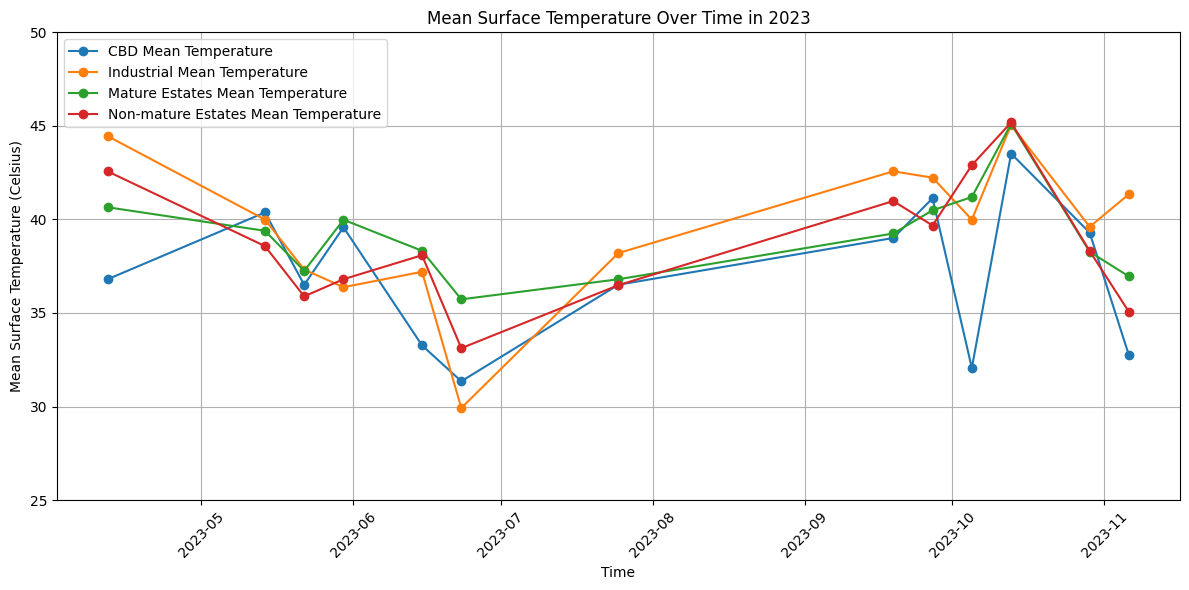

In [142]:
# cbd_pixels_2023 = cbd_pixels_2023[cbd_pixels_2023['region'] == 'DOWNTOWN CORE']

# Assuming 'time' in your dataframes is already converted to datetime type
cbd_pixels_2023['time'] = pd.to_datetime(cbd_pixels_2023['time'])
industrial_pixels['time'] = pd.to_datetime(industrial_pixels['time'])
mature_estates_pixels_2023['time'] = pd.to_datetime(mature_estates_pixels_2023['time'])
non_mature_estates_pixels_2023['time'] = pd.to_datetime(non_mature_estates_pixels_2023['time'])

# Filter data for the year 2023
industrial_pixels_2023 = industrial_pixels[industrial_pixels['time'].dt.year == 2023]

# Group by 'time' and calculate mean for each group
cbd_avg_2023 = cbd_pixels_2023.groupby('time').mean().reset_index()
industrial_avg_2023 = industrial_pixels_2023.groupby('time').mean().reset_index()
mature_estates_avg_2023 = mature_estates_pixels_2023.groupby('time').mean().reset_index()
non_mature_estates_avg_2023 = non_mature_estates_pixels_2023.groupby('time').mean().reset_index()

# # Convert 'time' to string to use as categorical x-axis
# cbd_avg_2023['time_str'] = cbd_avg_2023['time'].dt.strftime('%Y-%m-%d')
# industrial_avg_2023['time_str'] = industrial_avg_2023['time'].dt.strftime('%Y-%m-%d')
# mature_estates_avg_2023['time_str'] = mature_estates_avg_2023['time'].dt.strftime('%Y-%m-%d')
# non_mature_estates_avg_2023['time_str'] = non_mature_estates_avg_2023['time'].dt.strftime('%Y-%m-%d')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot average data for each dataframe using the string dates for equal spacing
ax.plot(cbd_avg_2023['time'], cbd_avg_2023['ST_B10_Celsius'], label='CBD Mean Temperature', marker='o')
ax.plot(industrial_avg_2023['time'], industrial_avg_2023['ST_B10_Celsius'], label='Industrial Mean Temperature', marker='o')
ax.plot(mature_estates_avg_2023['time'], mature_estates_avg_2023['ST_B10_Celsius'], label='Mature Estates Mean Temperature', marker='o')
ax.plot(non_mature_estates_avg_2023['time'], non_mature_estates_avg_2023['ST_B10_Celsius'], label='Non-mature Estates Mean Temperature', marker='o')

ax.set_title('Mean Surface Temperature Over Time in 2023')
ax.set_xlabel('Time')
ax.set_ylabel('Mean Surface Temperature (Celsius)')
ax.set_ylim(25, 50)
ax.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.grid(True)  # Adding grid for better visualization
plt.tight_layout()
plt.show()

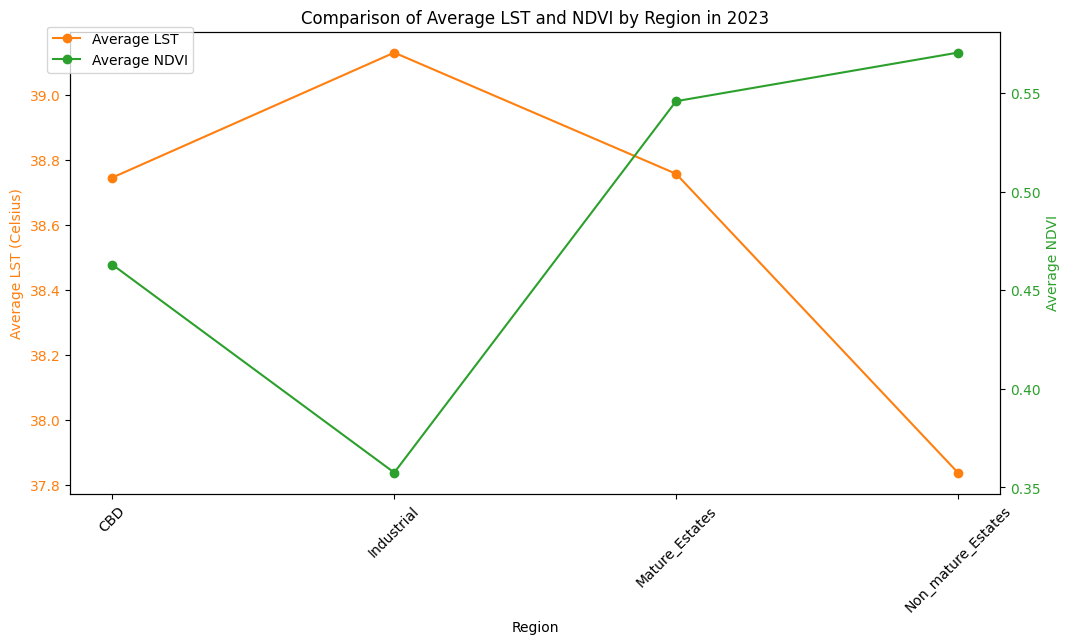

In [107]:
# Assuming all_pixels_2023 contains the required 'region' and 'time' columns and is filtered for 2023 already
# Group by 'region' and calculate mean for each group
region_avg_2023 = all_pixels_2023.groupby('region_reg').mean().reset_index()

# Sorting data by region for better visualization
region_avg_2023 = region_avg_2023.sort_values('region_reg')

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for average LST with primary y-axis
color = 'tab:orange'
ax1.set_xlabel('Region')
ax1.set_ylabel('Average LST (Celsius)', color=color)
ax1.plot(region_avg_2023['region_reg'], region_avg_2023['ST_B10_Celsius'], color=color, marker='o', label='Average LST')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)  # Rotate region names for better readability

# Create a second y-axis for average NDVI using the same x-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Average NDVI', color=color)
ax2.plot(region_avg_2023['region_reg'], region_avg_2023['NDVI'], color=color, marker='o', label='Average NDVI')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend with a bit of custom placement
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('Comparison of Average LST and NDVI by Region in 2023')
plt.show()

### Regression Analysis

In [103]:
# Ignore pandas warnings related to SettingWithCopy
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Add 'region' column to each dataframe if not already present
cbd_pixels_2023['region_reg'] = 'CBD'
industrial_pixels_2023['region_reg'] = 'Industrial'
mature_estates_pixels_2023['region_reg'] = 'Mature_Estates'
non_mature_estates_pixels_2023['region_reg'] = 'Non_mature_Estates'

# Concatenate all dataframes
all_pixels_2023 = pd.concat([cbd_pixels_2023, industrial_pixels_2023, mature_estates_pixels_2023, non_mature_estates_pixels_2023])

# Assuming the individual identifier is region and time is the time dimension
all_pixels_2023 = all_pixels_2023.set_index(['region', 'time'])

In [109]:
# Assuming your DataFrame 'all_pixels_2023' is already in long format and indexed by region and time
formula = 'ST_B10_Celsius ~ 1 + NDVI + TimeEffects + EntityEffects'
model = PanelOLS.from_formula(formula, data=all_pixels_2023)
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

c:\Users\teomi\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         ST_B10_Celsius   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):             -0.1187
No. Observations:              374034   R-squared (Within):               0.0016
Date:                Mon, Jul 01 2024   R-squared (Overall):              0.0021
Time:                        10:23:18   Log-likelihood                -9.877e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      559.54
Entities:                          39   P-value                           0.0000
Avg Obs:                       9590.6   Distribution:                F(1,373982)
Min Obs:                       4.0000                                           
Max Obs:                    5.118e+04   F-statistic (robust):             1.4722
                            

In [117]:
all_pixels_2023[all_pixels_2023['ST_B10_Celsius'].isnull() == True]['ST_B10']

region                          time      
Sungei Kadut Industrial Estate  2023-10-13   NaN
                                2023-10-13   NaN
                                2023-10-13   NaN
                                2023-07-25   NaN
                                2023-07-25   NaN
                                2023-07-25   NaN
                                2023-09-27   NaN
                                2023-10-29   NaN
                                2023-11-06   NaN
                                2023-11-06   NaN
                                2023-11-06   NaN
                                2023-04-12   NaN
Name: ST_B10, dtype: float64

For 2024

In [ ]:
# FOR 2024

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

singapore_geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\singapore-boundary.geojson"
nature_areas_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\nature areas\G_MP08_NAT_AREA_PL.geojson"
parks_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\parks\G_MP08_PARKS_PL.geojson"
water_bodies_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\water bodies\LBSTR_HYDRO.geojson"
regions_geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.geojson"

year = "2024"
dates_of_interest = ['20240202_031642', '20240218_031642', '20240313_031647', '20240617_031549']

landsat_folders = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9"
]

gdfs = []
temp_dir = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\temp_extract"
os.makedirs(temp_dir, exist_ok=True)

for folder in landsat_folders:
    zip_file_path = os.path.join(folder, f"{year}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
        # Update to include subdirectory handling
        year_dir = os.path.join(temp_dir, year)
        if os.path.exists(year_dir):
            for filename in os.listdir(year_dir):
                if filename.endswith(".tif") and any(date in filename for date in dates_of_interest):
                    print("Currently processing: " + filename)
                    file_path = os.path.join(year_dir, filename)
                    gdf = preprocessing_sg_excl_nature(file_path, regions_geojson_path, singapore_geojson_path, nature_areas_geojson, parks_geojson, water_bodies_geojson)
                    # Extract date and time from filename
                    time_str = filename.split('_')[2]
                    time_obj = datetime.strptime(time_str, "%Y%m%d")
                    gdf['time'] = time_obj
                    gdfs.append(gdf)
                    print(gdf.head())
                    print("Length of dataframe: " + str(len(gdfs)))
    shutil.rmtree(temp_dir)
    logging.info(f"Cleaned up temporary directory: {temp_dir}")

combined_excl_nature_2024 = pd.concat(gdfs) if gdfs else pd.DataFrame()
print(combined_excl_nature_2024)

Currently processing: L8_UTC_20240202_031642.tif
Total pixels before any joins: 1834333
Total pixels within Singapore boundary: 656003
Total number of valid pixels within remaining areas of Singapore: 598640
       Longitude  Latitude    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
2588  103.807065  1.469955  30922.0  31387.0  31079.0  31299.0  32724.0   
2589  103.807335  1.469955  30544.0  30920.0  31051.0  31190.0  32497.0   
2590  103.807605  1.469955  28322.0  29001.0  29287.0  29684.0  31733.0   
2591  103.807874  1.469955  24095.0  24847.0  25626.0  25977.0  28321.0   
2592  103.808144  1.469956  22122.0  22903.0  23673.0  24025.0  26454.0   

        SR_B6    SR_B7  SR_QA_AEROSOL  ...  ST_EMSD  ST_QA  ST_TRAD  ST_URAD  \
2588  25641.0  21302.0          224.0  ...      0.0  733.0   8157.0   5085.0   
2589  26943.0  22517.0          224.0  ...      0.0  725.0   8255.0   5085.0   
2590  27304.0  23205.0          224.0  ...      0.0  717.0   8371.0   5085.0   
2591  25721.0  22064.

In [4]:
combined_excl_nature_2024['ST_B10_Celsius'] = combined_excl_nature_2024['ST_B10']  * 0.00341802 + 149 - 273.15

# Scale and offset values for SR_B4 (Near Infrared) and SR_B5 (Shortwave Infrared 1)
scale = 2.75e-05
offset = -0.2

# Apply scale and offset to the bands
combined_excl_nature_2024['SR_B4_Scaled'] = (combined_excl_nature_2024['SR_B4'] * scale) + offset
combined_excl_nature_2024['SR_B5_Scaled'] = (combined_excl_nature_2024['SR_B5'] * scale) + offset

combined_excl_nature_2024['NDVI'] = (combined_excl_nature_2024['SR_B5_Scaled'] - combined_excl_nature_2024['SR_B4_Scaled']) / (combined_excl_nature_2024['SR_B5_Scaled'] + combined_excl_nature_2024['SR_B4_Scaled'])

combined_excl_nature_2024.rename(columns = {'name' : 'region'}, inplace=True)

In [5]:
# Convert 'time' to datetime if it's not already
combined_excl_nature_2024['time'] = pd.to_datetime(combined_excl_nature_2024['time'])

# Define the filtering values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filter out unwanted 'QA_PIXEL' values
filtered_gdf_excl_nature_2024 = combined_excl_nature_2024[~combined_excl_nature_2024['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Further filter out unwanted 'SR_QA_AEROSOL' values
filtered_gdf_excl_nature_2024 = filtered_gdf_excl_nature_2024[~filtered_gdf_excl_nature_2024['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

In [63]:
filtered_gdf_excl_nature_2024.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\2024_sg_excl_nature_cc30.csv")

In [13]:
print(filtered_gdf_excl_nature_2024['time'].unique())

['2024-02-02T00:00:00.000000000' '2024-02-18T00:00:00.000000000'
 '2024-03-13T00:00:00.000000000' '2024-06-17T00:00:00.000000000']


In [21]:
filtered_gdf_excl_nature_2024['region'].unique()

array(['SEMBAWANG', 'SIMPANG', 'WOODLANDS', 'LIM CHU KANG',
       'SUNGEI KADUT', 'MANDAI', 'NORTH-EASTERN ISLANDS',
       'WESTERN WATER CATCHMENT', 'CENTRAL WATER CATCHMENT',
       'CHOA CHU KANG', 'ANG MO KIO', 'PASIR RIS', 'CHANGI', 'SERANGOON',
       'BUKIT PANJANG', 'PAYA LEBAR', 'HOUGANG', 'BUKIT BATOK', 'TENGAH',
       'TAMPINES', 'BISHAN', 'JURONG WEST', 'JURONG EAST', 'TUAS',
       'BUKIT TIMAH', 'BEDOK', 'TOA PAYOH', 'NOVENA', 'CLEMENTI',
       'GEYLANG', 'BOON LAY', 'PIONEER', 'KALLANG', 'TANGLIN',
       'QUEENSTOWN', 'NEWTON', 'ROCHOR', 'MARINE PARADE', 'ORCHARD',
       'RIVER VALLEY', 'DOWNTOWN CORE', 'MUSEUM', 'WESTERN ISLANDS',
       'SINGAPORE RIVER', 'MARINA EAST', 'BUKIT MERAH', 'OUTRAM',
       'MARINA SOUTH', 'STRAITS VIEW', 'SOUTHERN ISLANDS', 'YISHUN',
       'SELETAR', 'PUNGGOL', 'SENGKANG', 'CHANGI BAY'], dtype=object)

In [131]:
cbd_regions = [
    "DOWNTOWN CORE", "STRAITS VIEW", "OUTRAM", "ROCHOR", "ORCHARD",
    "MARINA EAST", "MARINA SOUTH", "SINGAPORE RIVER", "RIVER VALLEY"
]

cbd_pixels = filtered_gdf_excl_nature_2024[filtered_gdf_excl_nature_2024['region'].isin(cbd_regions)]

In [122]:
cbd_pixels.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\CBD_cc30.csv")

In [42]:
# https://www.channelnewsasia.com/singapore/mature-estates-hdb-flats-classified-cna-explains-3581846 

mature_estates = [
    "ANG MO KIO", "BISHAN", "BUKIT MERAH", "BUKIT TIMAH", "CLEMENTI", "GEYLANG", "KALLANG", 
    "MARINE PARADE", "PASIR RIS", "QUEENSTOWN", "SERANGOON", "TAMPINES", "TOA PAYOH"
]

mature_estates_pixels = filtered_gdf_excl_nature_2024[filtered_gdf_excl_nature_2024['region'].isin(mature_estates)]

In [43]:
mature_estates_pixels.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\mature_estates_cc30.csv")

In [45]:
non_mature_estates = [
    "BUKIT BATOK", "BUKIT PANJANG", "CHOA CHU KANG", "HOUGANG", "JURONG EAST", "JURONG WEST", 
    "PUNGGOL", "SEMBAWANG", "SENGKANG", "TENGAH", "WOODLANDS", "YISHUN"
]

non_mature_estates_pixels = filtered_gdf_excl_nature_2024[filtered_gdf_excl_nature_2024['region'].isin(non_mature_estates)]

non_mature_estates_pixels.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\non_mature_estates_cc30.csv")

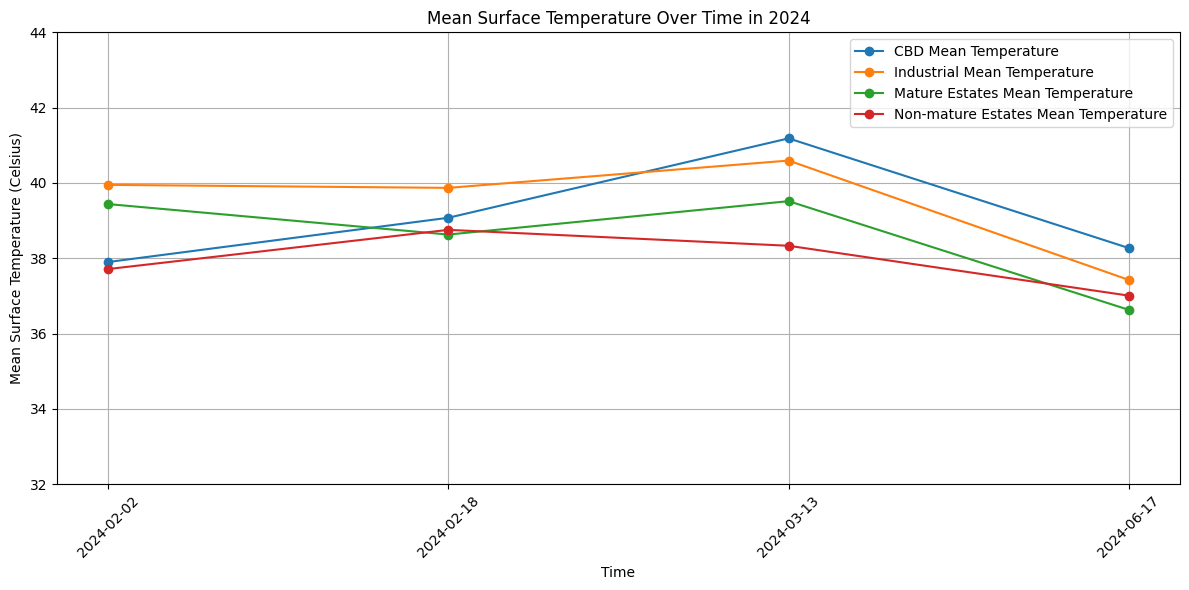

In [143]:
cbd_pixels = cbd_pixels[cbd_pixels['region'] == 'DOWNTOWN CORE']

# Assuming 'time' in your dataframes is already converted to datetime type
cbd_pixels['time'] = pd.to_datetime(cbd_pixels['time'])
industrial_pixels['time'] = pd.to_datetime(industrial_pixels['time'])
mature_estates_pixels['time'] = pd.to_datetime(mature_estates_pixels['time'])
non_mature_estates_pixels['time'] = pd.to_datetime(non_mature_estates_pixels['time'])

# Filter data for the year 2024
cbd_pixels_2024 = cbd_pixels[cbd_pixels['time'].dt.year == 2024]
industrial_pixels_2024 = industrial_pixels[industrial_pixels['time'].dt.year == 2024]

# Group by 'time' and calculate mean for each group
cbd_avg_2024 = cbd_pixels_2024.groupby('time').mean().reset_index()
industrial_avg_2024 = industrial_pixels_2024.groupby('time').mean().reset_index()
mature_estates_avg = mature_estates_pixels.groupby('time').mean().reset_index()
non_mature_estates_avg = non_mature_estates_pixels.groupby('time').mean().reset_index()

# Convert 'time' to string to use as categorical x-axis
cbd_avg_2024['time_str'] = cbd_avg_2024['time'].dt.strftime('%Y-%m-%d')
industrial_avg_2024['time_str'] = industrial_avg_2024['time'].dt.strftime('%Y-%m-%d')
mature_estates_avg['time_str'] = mature_estates_avg['time'].dt.strftime('%Y-%m-%d')
non_mature_estates_avg['time_str'] = non_mature_estates_avg['time'].dt.strftime('%Y-%m-%d')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot average data for each dataframe using the string dates for equal spacing
ax.plot(cbd_avg_2024['time_str'], cbd_avg_2024['ST_B10_Celsius'], label='CBD Mean Temperature', marker='o')
ax.plot(industrial_avg_2024['time_str'], industrial_avg_2024['ST_B10_Celsius'], label='Industrial Mean Temperature', marker='o')
ax.plot(mature_estates_avg['time_str'], mature_estates_avg['ST_B10_Celsius'], label='Mature Estates Mean Temperature', marker='o')
ax.plot(non_mature_estates_avg['time_str'], non_mature_estates_avg['ST_B10_Celsius'], label='Non-mature Estates Mean Temperature', marker='o')

ax.set_title('Mean Surface Temperature Over Time in 2024')
ax.set_xlabel('Time')
ax.set_ylabel('Mean Surface Temperature (Celsius)')
ax.set_ylim(32, 44)
ax.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.grid(True)  # Adding grid for better visualization
plt.tight_layout()
plt.show()

In [ ]:
# Group CBD regions together: DOWNTOWN CORE, STRAITS VIEW, OUTRAM, ROCHOR, ORCHARD, MARINA EAST, MARINA SOUTH, SINGAPORE RIVER, RIVER VALLEY
# Group industrial regions together: TUAS, PIONEER, SUNGEI KADUT

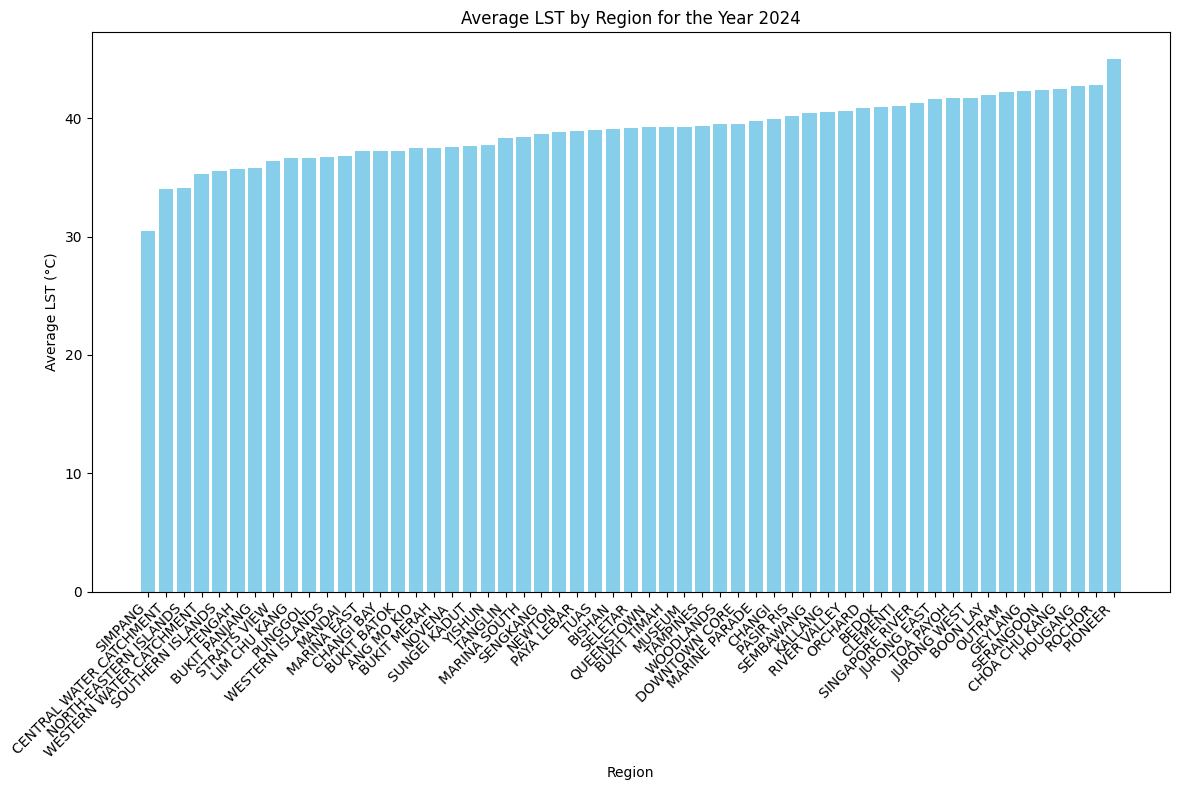

In [6]:
# Regions across Singapore sorted by average LST for the year 2024 
# Check if any data is present for the year
if filtered_gdf_excl_nature_2024.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean LST for each region
    mean_lst_by_region = filtered_gdf_excl_nature_2024.groupby('region')['ST_B10_Celsius'].mean().reset_index()

    # Sort the DataFrame by LST in ascending order
    mean_lst_by_region = mean_lst_by_region.sort_values('ST_B10_Celsius')
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_lst_by_region['region'], mean_lst_by_region['ST_B10_Celsius'], color='skyblue')
    plt.xlabel('Region')
    plt.ylabel('Average LST (°C)')
    plt.title('Average LST by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

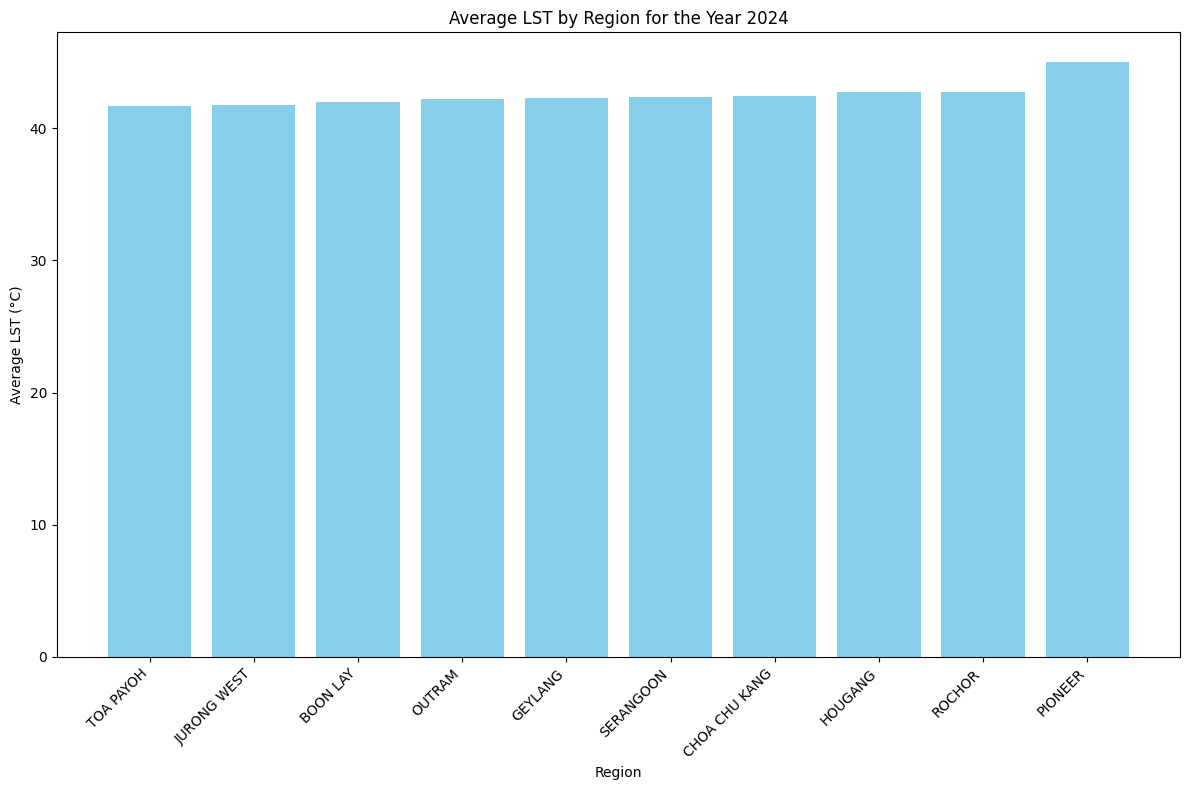

In [7]:
# TOP 10 regions across Singapore sorted by average LST for the year 2024 
# Check if any data is present for the year
if filtered_gdf_excl_nature_2024.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean LST for each region
    mean_lst_by_region = filtered_gdf_excl_nature_2024.groupby('region')['ST_B10_Celsius'].mean().reset_index()

    # Sort the DataFrame by LST in ascending order
    mean_lst_by_region_top_10 = mean_lst_by_region.sort_values('ST_B10_Celsius').tail(10)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_lst_by_region_top_10['region'], mean_lst_by_region_top_10['ST_B10_Celsius'], color='skyblue')
    plt.xlabel('Region')
    plt.ylabel('Average LST (°C)')
    plt.title('Average LST by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

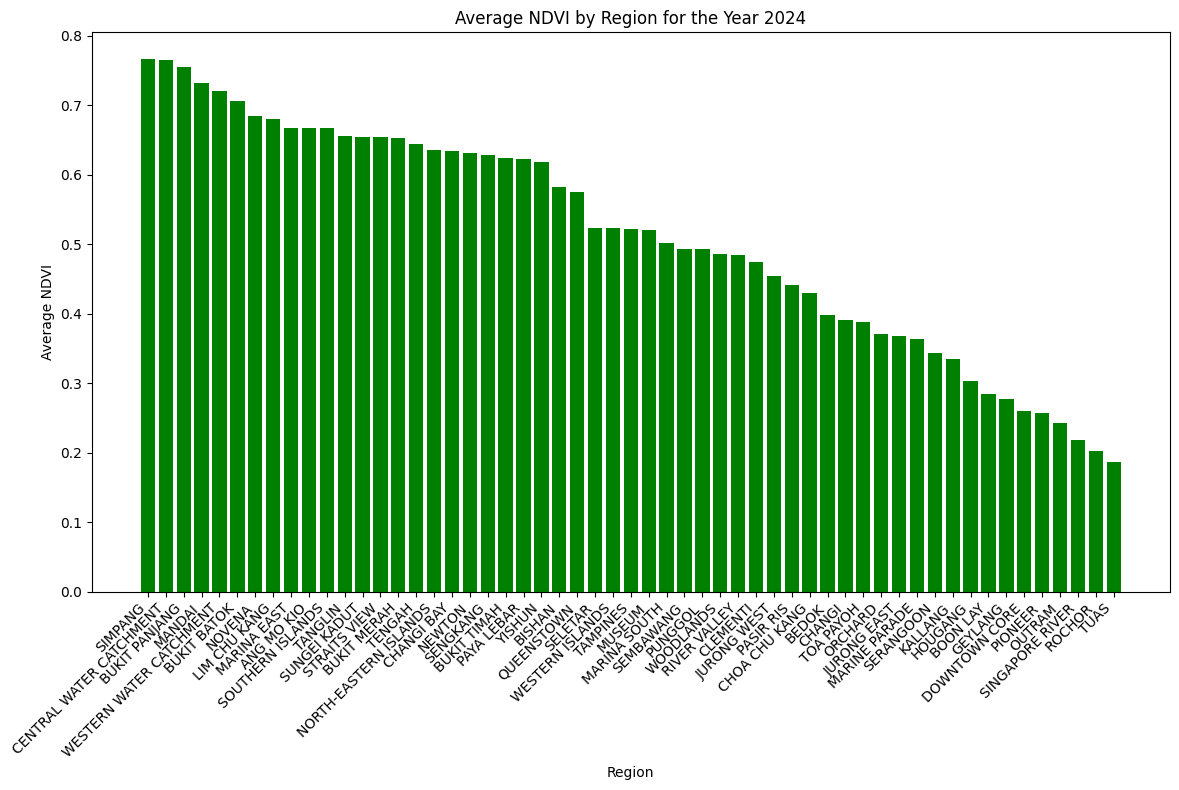

In [8]:
# Regions across Singapore sorted by average NDVI in descending order for the year 2024 
# Check if any data is present for the year
if filtered_gdf_excl_nature_2024.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean NDVI for each region
    mean_ndvi_by_region = filtered_gdf_excl_nature_2024.groupby('region')['NDVI'].mean().reset_index()

    # Sort the DataFrame by NDVI in ascending order
    mean_ndvi_by_region = mean_ndvi_by_region.sort_values('NDVI', ascending=False)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_ndvi_by_region['region'], mean_ndvi_by_region['NDVI'], color='green')
    plt.xlabel('Region')
    plt.ylabel('Average NDVI')
    plt.title('Average NDVI by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

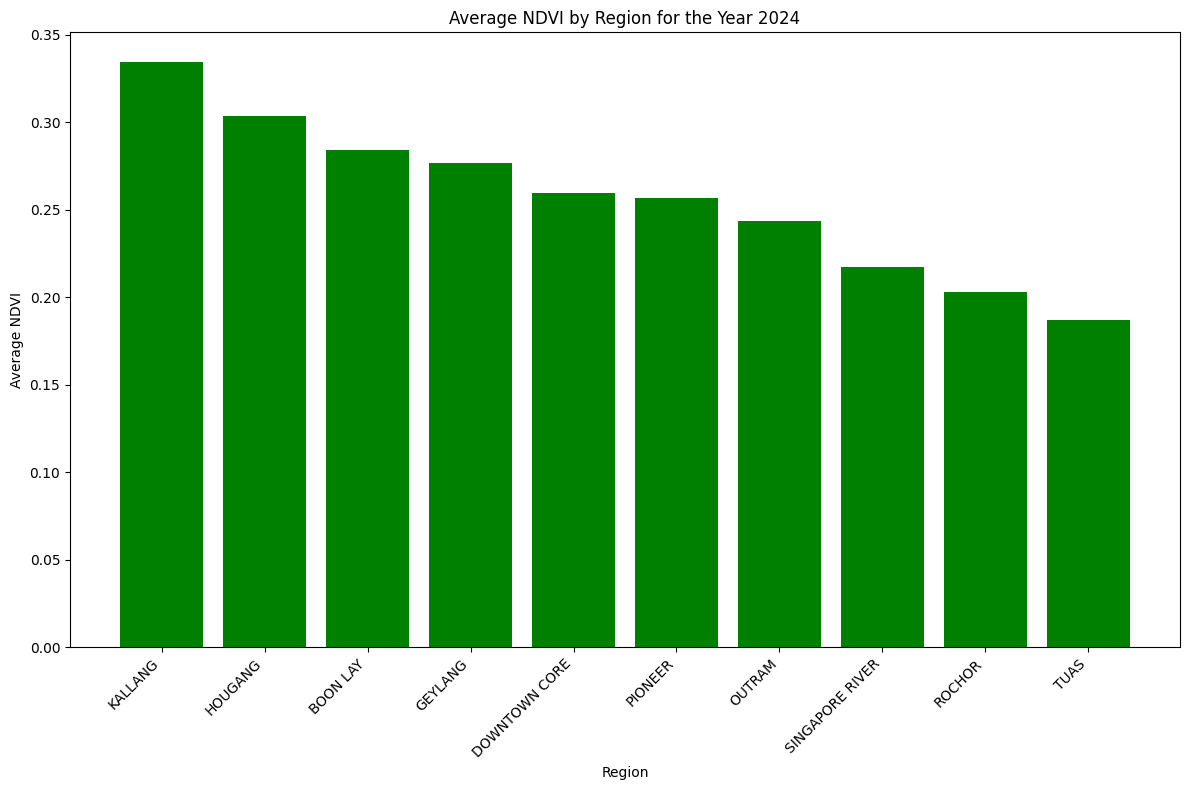

In [9]:
# TOP 10 regions across Singapore sorted by average NDVI in descending order for the year 2024 
# Check if any data is present for the year
if filtered_gdf_excl_nature_2024.empty:
    print("No data available for the year 2024.")
else:
    # Calculate mean NDVI for each region
    mean_ndvi_by_region = filtered_gdf_excl_nature_2024.groupby('region')['NDVI'].mean().reset_index()

    # Sort the DataFrame by NDVI in ascending order
    mean_ndvi_by_region_top_10 = mean_ndvi_by_region.sort_values('NDVI', ascending=False).tail(10)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.bar(mean_ndvi_by_region_top_10['region'], mean_ndvi_by_region_top_10['NDVI'], color='green')
    plt.xlabel('Region')
    plt.ylabel('Average NDVI')
    plt.title('Average NDVI by Region for the Year 2024')
    plt.xticks(rotation=45, ha="right")  # Rotate region names for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

In [10]:
# Assuming mean_lst_by_region and mean_ndvi_by_region are already defined
# and both contain a column named 'region' with the names of the regions.

# Convert the 'region' columns from both dataframes to sets
mean_lst_by_region_top_10_set = set(mean_lst_by_region_top_10['region'])
mean_ndvi_by_region_top_10_set = set(mean_ndvi_by_region_top_10['region'])

# Find the intersection of both sets
intersecting_regions = mean_lst_by_region_top_10_set.intersection(mean_ndvi_by_region_top_10_set)

# Print the intersecting region names
print("Intersecting Regions:")
for region in intersecting_regions:
    print(region)

print(f"\n{len(intersecting_regions)} of the top 10 regions with highest average LST have also have the lowest NDVI in Singapore")

Intersecting Regions:
OUTRAM
GEYLANG
PIONEER
BOON LAY
HOUGANG
ROCHOR

6 of the top 10 regions with highest average LST have also have the lowest NDVI in Singapore


### Scatter Plot and Correlation Analysis of Average LST and Average NDVI

In [92]:
# Merge the NDVI and LST dataframes on region
combined_excl_nature_averages_2024 = pd.merge(mean_ndvi_by_region, mean_lst_by_region, on='region')

In [93]:
combined_excl_nature_averages_2024

,region,NDVI,ST_B10_Celsius
0,ANG MO KIO,0.300044,38.172020
1,BEDOK,0.189949,40.581501
2,BISHAN,0.241304,39.130703
3,BOON LAY,0.151075,40.483578
4,BUKIT BATOK,0.327316,36.457062
5,BUKIT MERAH,0.302557,36.175774
6,BUKIT PANJANG,0.324853,35.268311
7,BUKIT TIMAH,0.289489,38.586487
8,CENTRAL WATER CATCHMENT,0.331652,33.531078
9,CHANGI,0.191070,38.635777


In [ ]:
# Correlation analysis
correlation_coefficient, p_value = pearsonr(combined_data['NDVI'], combined_data['ST_B10_Celsius'])
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: -0.7611485007126049
P-value: 1.5300540954723862e-11


### Spatial Plot of Average LST and Average NDVI

In [ ]:
# Path to the GeoJSON file
geojson_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.geojson"

# Read the GeoJSON file using Geopandas
gdf = gpd.read_file(geojson_path)

# # Save the DataFrame to CSV
# csv_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\sg-planning-area.csv"
# gdf.to_csv(csv_path, index=False)

# print(f"Data has been successfully saved to {csv_path}")

In [ ]:
print(gdf)

                       name                                           geometry
0                    BISHAN  POLYGON ((103.84924 1.36275, 103.84936 1.36268...
1               BUKIT BATOK  POLYGON ((103.76408 1.37001, 103.76444 1.36947...
2               BUKIT MERAH  POLYGON ((103.81740 1.29433, 103.81743 1.29431...
3             BUKIT PANJANG  POLYGON ((103.77445 1.39029, 103.77499 1.38607...
4               BUKIT TIMAH  POLYGON ((103.79766 1.34813, 103.79806 1.34779...
5   CENTRAL WATER CATCHMENT  POLYGON ((103.80702 1.41126, 103.80754 1.40986...
6                    CHANGI  POLYGON ((103.98236 1.39356, 103.98242 1.39349...
7                CHANGI BAY  MULTIPOLYGON (((104.02076 1.32566, 104.02139 1...
8             CHOA CHU KANG  POLYGON ((103.74660 1.40541, 103.74691 1.40540...
9                  CLEMENTI  POLYGON ((103.75857 1.29929, 103.75831 1.29911...
10                  GEYLANG  POLYGON ((103.90179 1.30975, 103.90150 1.30954...
11                   NOVENA  POLYGON ((103.83599 1.3

In [ ]:
# Renaming GDF's 'name' column
gdf = gdf.rename(columns={'name': 'region'})

# Merging GeoJSON and `combined_gdf` of Average LST and Average NDVI across regions
merged_gdf = gdf.merge(combined_data, on='region')

In [ ]:
# AVERAGE LST PLOT
colors = [
    '#4b6fb9',  # Soft blue
    '#76c8d8',  # Soft cyan
    '#f4e4a2',  # Soft yellow
    '#ffa500',  # More vibrant orange
    '#db4b4b'   # Soft red
]

temperature_cmap = LinearSegmentedColormap.from_list("temperature", colors, N=256)

# Plot using hvPlot with polygons colored by average LST
avg_LST_plot = merged_gdf.hvplot(
    geo=True,  # Enable geographic contextual rendering
    c='ST_B10_Celsius',  # Column to color by
    cmap=temperature_cmap,  # Color map
    tiles='OSM',
    hover_cols=['region', 'ST_B10_Celsius'],  # Data to show on hover
    title='Average LST by Region',
    width=700,
    height=500
)

# Display the plot
avg_LST_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (ST_B10_Celsius,region)

In [ ]:
# AVERAGE NDVI PLOT
# Define colors as [beige, light green, dark green]
colors = ["#fffde5", "#addd8e", "#31a354", "#006837"]  # Approximations from the image
n_bins = 256  # More bins will make the color transition smoother
cmap_name = "custom_ndvi"

# Create the colormap
NDVI_cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot using hvPlot with polygons colored by average LST
avg_NDVI_plot = merged_gdf.hvplot(
    geo=True,  # Enable geographic contextual rendering
    c='NDVI',  # Column to color by
    cmap=NDVI_cm,  # Color map
    tiles='OSM',
    hover_cols=['region', 'NDVI'],  # Data to show on hover
    title='Average NDVI by Region',
    width=700,
    height=500
)

# Display the plot
avg_NDVI_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (NDVI,region)

Test plot for nature areas, water bodies and parks

In [23]:
# Path to the GeoJSON file
nature_areas_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\nature areas\G_MP08_NAT_AREA_PL.geojson"
parks_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\parks\G_MP08_PARKS_PL.geojson"
water_bodies_geojson = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\nature areas parks water bodies\water bodies\LBSTR_HYDRO.geojson"

# Read the GeoJSON file using Geopandas
nature_areas_gdf = gpd.read_file(nature_areas_geojson)
parks_gdf = gpd.read_file(parks_geojson)
water_bodies_gdf = gpd.read_file(water_bodies_geojson)

print(nature_areas_gdf.head())
print(parks_gdf.head())
print(water_bodies_gdf.head())

   OBJECTID_1  UNIQUE_ID          NAME           INC_CRC      FMEL_UPD_D  \
0           1        539          None          E8398861  20110401130930   
1           2        540          None          D6B62998  20110401130930   
2           3        541          None          DB74D487  20110401130930   
3           4        542  PULAU PERGAM  B17C16E361C5A133  20110401130930   
4           5        543          None          852F5590  20110401130930   

   SHAPE_1.AREA   SHAPE_1.LEN  \
0  1.265634e+05   2674.448777   
1  4.079503e+03    262.423942   
2  2.840024e+04    727.048809   
3  2.800020e+04    740.290797   
4  2.175472e+06  24954.182362   

                                            geometry  
0  POLYGON ((103.66715 1.40927, 103.66707 1.40872...  
1  POLYGON ((103.66739 1.40768, 103.66751 1.40757...  
2  POLYGON ((103.67274 1.41395, 103.67251 1.41387...  
3  POLYGON ((103.66100 1.39677, 103.66113 1.39681...  
4  POLYGON ((103.66237 1.39486, 103.66237 1.39479...  
   OBJECTID_1 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


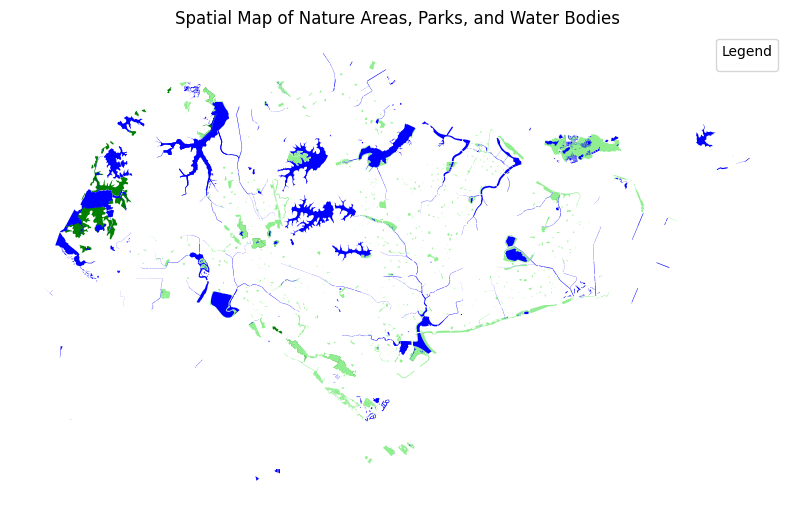

In [49]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each GeoDataFrame with different colors
nature_areas_gdf.plot(ax=ax, color='green', label='Nature Areas')
parks_gdf.plot(ax=ax, color='lightgreen', label='Parks')
water_bodies_gdf.plot(ax=ax, color='blue', label='Water Bodies')

# Add legend and titles
ax.legend(title='Legend')
ax.set_title('Spatial Map of Nature Areas, Parks, and Water Bodies')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove axis for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()